# Introduction

This notebook is built on top of the work of [Rich Olson](https://www.kaggle.com/richolson). The source notebook is [CMI 2025: 1D CNN IMU-Only Baseline
](https://www.kaggle.com/code/richolson/cmi-2025-1d-cnn-imu-only-baseline).

My final solution is an ensemble of two models. This notebook implements the second model which is trained with hard labels. The Kaggle notebook of the solution is available here(https://www.kaggle.com/code/naresh/cmi-behavior-detection-lstm?scriptVersionId=257063621).

| Category (train)  |  Counts | Values|
|---|---|---|
| row_id | 1 ||
| sequence_type | 1 ||
| sequence_id | 1 ||
| sequence_counter | 1 ||
| subject | 1 ||
| orientation | 1 ||
| behavior | 1 ||
| phase | 1 ||
| gesture | 1 ||
| acc | 3 |acc_x,acc_y,acc_z|
| rot | 4 |rot_w,rot_x,rot_y,rot_z|
| thm | 5 |thm_1,thm_2,...,thm_5|
| tof | 64x4 |tof_1_v0'...tof_1_v63,tof_2_v0'...tof_2_v63,tof_3_v0'...tof_3_v63,tof_4_v0'...tof_4_v63|

| Category (test)  |  Counts | Values|
|---|---|---|
| row_id | 1 ||
| <strike>sequence_type</strike>| 1 ||
| sequence_id | 1 ||
| sequence_counter | 1 ||
| subject | 1 ||
| <strike>orientation</strike> | 1 ||
| <strike>behavior</strike> | 1 ||
| <strike>phase</strike> | 1 ||
| <strike>gesture</strike> | 1 ||
| acc | 3 |acc_x,acc_y,acc_z|
| rot | 4 |rot_w,rot_x,rot_y,rot_z|
| thm | 5 |thm_1,thm_2,...,thm_5|
| tof | 64x4 |tof_1_v0'...tof_1_v63,tof_2_v0'...tof_2_v63,tof_3_v0'...tof_3_v63,tof_4_v0'...tof_4_v63|

| Version  | Changes |
|---|---|
| 11 | base |
| 16 | slides |

### TODO
- [x] Tune LR.

### Changes
- [] .

# Setup Environment

## Configurations

In [1]:
import torch

from pathlib import Path
from torch import nn
from dataclasses import dataclass, field
from typing import List, Dict, Callable
from core_utilities import set_seed

@dataclass
class Config:
    seed: int = 42
    eps: float = 1e-8
    
    root: Path = Path('/kaggle/input/cmi-detect-behavior-with-sensor-data/')
    ckpt_root: Path = Path('/kaggle/input/cmi-behavior-detection/lightning_logs/version_0/checkpoints')
    # data_root: Path = Path('/kaggle/input/cmi-tof-dataset')
    data_root: Path = Path('/kaggle/input/cmi-behavior-detection-synthetic-dataset')
    
    # Data groups (train, test, ...)
    data_groups: dict[str, str] = field(default_factory=lambda: dict(
        train='train.csv',
        test='test.csv',
    ))
    
    # Demographics data
    demographics: dict[str, str] = field(default_factory=lambda: dict(
        train='train_demographics.csv',
        test='test_demographics.csv',
    ))

    # Split ratio
    split_ratio: float = 0.2

    # Torch Configuration
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    
    # Feature Flags
    features: List[str] = field(default_factory=lambda: [
        ## Info
        'info.splits',
        # 'info.dataset',
        # 'info.transforms',
        'info.datasets',
        'info.dataloader.params',
        'info.dataloader.summary',

        ## Data Processing
        # 'data.linear_acc',
        # 'data.linear_acc.overwrite',
        # 'data.move_between_sets',

        ## Model
        'model.summary',

        ## Training
        'train',
        'train.metrics',
        # 'train.save.latest',
        # 'checkpoint',

        ## Evaluation
        'evaluation.valid',
        'evaluation.valid.sliced',
        # 'evaluation.composite.sliced',

        ## Competition Metrics
        # 'competition.metrics.valid',
        'competition.metrics.test',

    ])

    def data_limit(self) -> int:
        return 3 if is_interactive() else None

config = Config()
# print(f'{config=}')
set_seed(config.seed)

In [2]:
from dataclasses import dataclass, field
from typing import List

@dataclass
class DataConfig:
    slice_len: int = 64
    sequence_len: int = 103

    # Classes
    num_classes: int = 18

    column_to_str: {str, List[str]} = field(default_factory=lambda: {
        ## Metadata columns
        'metadata': ['row_id', 'sequence_id', 'sequence_counter', 'subject'],
        'metadata_d': ['subject'],

        ## Data Columns
        'acc': ['acc_x', 'acc_y', 'acc_z'],
        'rot': ['rot_w', 'rot_x', 'rot_y', 'rot_z'],
        'thm': [f'thm_{v}' for v in range(1, 6)],
        'tof': (
            [f'tof_1_v{v}' for v in range(64)]
            + [f'tof_2_v{v}' for v in range(64)]
            + [f'tof_3_v{v}' for v in range(64)]
            + [f'tof_4_v{v}' for v in range(64)]
        ),
        ## Demographics Columns
        'd': ['adult_child', 'handedness'],

        ## Label Columns
        'label': ['gesture'],

        ## Generated Columns
        'linear_acc': list(map(lambda s: f'linear_{s}', ['acc_x', 'acc_y', 'acc_z']))
    })

    def columns(self, hint=['acc', 'rot', 'tof', 'd']):
        # Convert hint to a list for processing
        if type(hint) is str: hint = [hint]

        return sum(map(lambda h: self.column_to_str[h], hint), [])

    def sequence_columns(self, generated=[]):
        return self.columns(['acc', 'rot', 'thm', 'tof', 'd'] + generated)
        
data_config = DataConfig(slice_len=64, sequence_len=64)

print(f'{data_config=}')

data_config=DataConfig(slice_len=64, sequence_len=64, num_classes=18, column_to_str={'metadata': ['row_id', 'sequence_id', 'sequence_counter', 'subject'], 'metadata_d': ['subject'], 'acc': ['acc_x', 'acc_y', 'acc_z'], 'rot': ['rot_w', 'rot_x', 'rot_y', 'rot_z'], 'thm': ['thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5'], 'tof': ['tof_1_v0', 'tof_1_v1', 'tof_1_v2', 'tof_1_v3', 'tof_1_v4', 'tof_1_v5', 'tof_1_v6', 'tof_1_v7', 'tof_1_v8', 'tof_1_v9', 'tof_1_v10', 'tof_1_v11', 'tof_1_v12', 'tof_1_v13', 'tof_1_v14', 'tof_1_v15', 'tof_1_v16', 'tof_1_v17', 'tof_1_v18', 'tof_1_v19', 'tof_1_v20', 'tof_1_v21', 'tof_1_v22', 'tof_1_v23', 'tof_1_v24', 'tof_1_v25', 'tof_1_v26', 'tof_1_v27', 'tof_1_v28', 'tof_1_v29', 'tof_1_v30', 'tof_1_v31', 'tof_1_v32', 'tof_1_v33', 'tof_1_v34', 'tof_1_v35', 'tof_1_v36', 'tof_1_v37', 'tof_1_v38', 'tof_1_v39', 'tof_1_v40', 'tof_1_v41', 'tof_1_v42', 'tof_1_v43', 'tof_1_v44', 'tof_1_v45', 'tof_1_v46', 'tof_1_v47', 'tof_1_v48', 'tof_1_v49', 'tof_1_v50', 'tof_1_v51', 'tof_1_v5

# Train/Valid Split

In [3]:
from core_utilities import make_header, load_pkl

print(f'Loading data from: {config.data_root}')

## Train set
train_X = load_pkl(config.data_root / 'train_X.pkl')
train_y = load_pkl(config.data_root / 'train_y.pkl')

## Valid set
valid_X = load_pkl(config.data_root / 'valid_X.pkl')
valid_y = load_pkl(config.data_root / 'valid_y.pkl')

if 'info.splits' in config.features:
    print(make_header('Train'))
    print(f'{len(train_X)} {train_X[0].shape=} {train_y.shape=}')
    
    print(make_header('Valid'))
    print(f'{len(valid_X)} {valid_X[0].shape=} {valid_y.shape=}')

Loading data from: /kaggle/input/cmi-behavior-detection-synthetic-dataset

Train
=====

6520 train_X[0].shape=(57, 273) train_y.shape=(6520,)

Valid
=====

1631 valid_X[0].shape=(45, 273) valid_y.shape=(1631,)


In [4]:
import numpy as np

def switch_acc_with_linear_acc(data):
    return list(map(
        lambda X: np.concatenate([X[..., -3:], X[..., 3:-3]], axis=-1),
        data
    ))

def remove_linear_acc(data):
    return list(map(
        lambda X: X[..., :-3],
        data
    ))

def move_between_sets(data_1, data_2, frac=.5):
    data_1_X, data_1_y = data_1
    data_2_X, data_2_y = data_2
    
    num_items = len(data_2_X)
    num_items_to_move = int(num_items*frac)

    # Move data_2_X to data_1_X
    data_1_X = data_1_X + data_2_X[:num_items_to_move]
    data_2_X = data_2_X[num_items_to_move:]

    # Move data_2_y to data_1_y
    data_1_y = np.concatenate([data_1_y, data_2_y[:num_items_to_move]])
    data_2_y = data_2_y[num_items_to_move:]

    return (data_1_X, data_1_y), (data_2_X, data_2_y)

if 'data.linear_acc.overwrite' in config.features:
    train_X = switch_acc_with_linear_acc(train_X)
    valid_X = switch_acc_with_linear_acc(valid_X)
elif not 'data.linear_acc' in config.features:
    train_X = remove_linear_acc(train_X)
    valid_X = remove_linear_acc(valid_X)

if 'data.move_between_sets' in config.features:
    # (train_X, train_y), (valid_X, valid_y) = move_between_sets(
    #     (train_X, train_y),
    #     (valid_X, valid_y),
    #     frac=.1,
    # )
    (valid_X, valid_y), (train_X, train_y) = move_between_sets(
        (valid_X, valid_y),
        (train_X, train_y),
        frac=.1,
    )

print(make_header('Train'))
print(f'{len(train_X)} {train_X[0].shape=} {train_y.shape=}')

print(make_header('Valid'))
print(f'{len(valid_X)} {valid_X[0].shape=} {valid_y.shape=}')


Train
=====

6520 train_X[0].shape=(57, 270) train_y.shape=(6520,)

Valid
=====

1631 valid_X[0].shape=(45, 270) valid_y.shape=(1631,)


## Class Weights

In [5]:
import numpy as np

def compute_class_weights(ys):
    _, freqs = np.unique(ys, return_counts=True)
    weights = freqs / len(ys)

    return weights

train_class_weights = compute_class_weights(train_y)
valid_class_weights = compute_class_weights(valid_y)

print(make_header(f'Class Weights (train)'))
print(train_class_weights)

print(make_header(f'Class Weights (valid)'))
print(valid_class_weights)


Class Weights (train)

[0.07929448 0.07852761 0.01932515 0.07546012 0.08128834 0.01947853
 0.07546012 0.07684049 0.01978528 0.0791411  0.08144172 0.01886503
 0.0607362  0.0196319  0.07745399 0.06027607 0.05858896 0.01840491]

Class Weights (valid)

[0.07418761 0.0766401  0.02145923 0.08951563 0.06744329 0.02084611
 0.09074188 0.08522379 0.01961987 0.07602698 0.06683017 0.02329859
 0.04966278 0.02023299 0.08277131 0.05211527 0.05824647 0.02513795]


# Datasets

It build a sequence by grouping the data by _sequence\_id_.

## Definition

In [6]:
import torch
import random
import numpy as np

class CMIDataset(torch.utils.data.Dataset):
    def __init__(self, Xs, ys=None, transforms=[], variants=1, merge_fn=lambda Xs,y: (Xs[0], y)):
        # Input args
        self.Xs = Xs
        self.ys = ys
        self.transforms = transforms
        self.variants = variants
        self.merge_fn = merge_fn

    def __len__(self):
        return len(self.Xs)

    def get_single_variant(self, X, y):
        # Apply transformations
        for t in self.transforms:
            X, y = t(X, y)

        return X, y

    def get_variants(self, X, y):
        # Create a container for variants
        Xs = []

        # Fetch the required number of variants
        for _ in range(self.variants):
            Xv, _ = self.get_single_variant(X, y)

            # Add variants to the container
            Xs.append(Xv)

        return Xs, y

    def __getitem__(self, idx):
        # Get X and y for the input idx
        X = self.Xs[idx]
        y = None if self.ys is None else self.ys[idx]

        # Get all variants of X and y
        Xs, y = self.get_variants(X, y)

        # Merge variants
        X, y = self.merge_fn(Xs, y)
        
        return X if y is None else (X, y)

    def __repr__(self):
        idx = random.randrange(len(self))
        X, y = (self[idx], None) if self.ys is None else self[idx]

        if self.variants == 1:
            repr_str = f'Length: {len(self)}\n{idx=}\n{X.shape=}\n{X[0]=}\n{X[-1]=}\n{y=}'
        else:
            repr_str = f'Length: {len(self)}\n{idx=}\n{X.shape=}\n{X[0][0]=}\n{X[0][-1]=}\n{X[1][0]=}\n{X[1][-1]=}\n{y=}'

        return repr_str

if 'info.dataset' in config.features:
    dataset = CMIDataset(train_X, train_y)
    print(f'{dataset=}')

## Transforms

In [7]:
from core_utilities import make_header
from transforms import Slice, FixLength, Transpose, ToType, Resize

transforms = [
    Slice(data_config.sequence_len),
    FixLength(data_config.sequence_len),
    Transpose(),
    ToType(),
]

if 'info.transforms' in config.features:
    print(make_header(f'Train'))
    dataset = CMIDataset(train_X, train_y, transforms=transforms)
    print(f'{dataset=}')

## Train and Valid Datasets

In [8]:
from core_utilities import make_header
from transforms import Slice, FixLength, Transpose, ToType, Resize, Holes, Clip, LambdaX, OffChannel

# Make train set
train_transforms = [
    Slice(data_config.sequence_len),
    Clip(limits=(-3.5, 2.5)),
    FixLength(data_config.sequence_len),
    # Holes(count=6),
    Holes(count=128),
    OffChannel(
        len(data_config.columns(['acc', 'rot'])),
        len(data_config.columns(['thm', 'tof'])),
    ),
    Transpose(),
    ToType(),
]

train_set = CMIDataset(train_X, train_y, transforms=train_transforms)

# Make valid set
valid_transforms = [
    Slice(data_config.sequence_len),
    Clip(limits=(-3.5, 2.5)),
    FixLength(data_config.sequence_len),
    OffChannel(
        len(data_config.columns(['acc', 'rot'])),
        len(data_config.columns(['thm', 'tof'])),
    ),
    Transpose(),
    ToType(),
]

valid_set = CMIDataset(valid_X, valid_y, transforms=valid_transforms)

if 'info.datasets' in config.features:
    print(make_header(f'Train'))
    print(f'{train_set=}')

    print(make_header(f'Valid'))
    print(f'{valid_set=}')


Train
=====

train_set=Length: 6520
idx=5238
X.shape=(270, 64)
X[0]=array([ 0.8964472 ,  0.9203771 ,  0.72056216,  0.7618413 ,  0.92576134,
        0.8731155 ,  0.8557663 ,  0.8497838 ,  0.8497838 ,  0.8438013 ,
        0.8438013 ,  0.8438013 ,  0.8438013 ,  0.83183634,  0.83183634,
        0.83183634,  0.82645214,  0.8497838 ,  0.8204696 ,  0.81448716,
        0.81448716,  0.8085047 ,  0.797138  ,  0.83183634,  0.81448716,
        0.8085047 ,  0.8025222 ,  0.797138  ,  0.797138  ,  0.797138  ,
        0.797138  ,  0.797138  ,  0.797138  ,  0.797138  ,  0.773208  ,
        0.797138  ,  0.8085047 ,  0.7678238 ,  0.6152705 ,  0.6499689 ,
        0.74389386,  0.7265447 ,  0.7265447 ,  0.773208  ,  0.9143946 ,
        0.15761058,  0.20427395, -0.30004933, -1.0514491 , -1.0975143 ,
       -1.1441776 , -1.1274266 , -1.1214441 , -1.1094792 , -1.1561426 ,
       -1.2093867 , -1.1681075 , -1.1447759 , -1.1986182 , -1.2034042 ,
       -1.1687058 , -1.1920375 , -1.2034042 , -1.1280249 ], dtype=f

# Model

## BDLstmModel

In [9]:
from pathlib import Path
from dataclasses import dataclass, field
from collections.abc import Callable

@dataclass
class ModelConfig:
    model: str = 'BDLstmModel'

    # Required configuration
    input_size: int = 64
    out_channels: int = 18

    # Input split configuration
    in_splits: list[int] = field(default_factory=lambda: [3, 4, 5, 256, 2])
    in_encoders: list[str] = field(default_factory=lambda: ['acc', 'rot', 'thm', 'tof', 'dem'])

    # Input slice configuration
    slice_encoders: dict[str, tuple[int]] = field(default_factory=lambda: {
        # 'acc_rot': [slice(7)],
    })

    # Optional configuration
    rnn_channels: int = 64
    squeeze_channels: int = 128
    
    # Optional layers
    with_noise: bool = False
    
    def input_shape(self) -> tuple[int, int]:
        return (self.input_size, self.in_channels)

    @property
    def in_channels(self) -> int:
        return sum(self.in_splits)

model_config = ModelConfig(
    input_size=data_config.sequence_len,
    rnn_channels=data_config.sequence_len,
    squeeze_channels=32,
)
print(f'{model_config=}')
print(f'{model_config.input_shape()=}')

model_config=ModelConfig(model='BDLstmModel', input_size=64, out_channels=18, in_splits=[3, 4, 5, 256, 2], in_encoders=['acc', 'rot', 'thm', 'tof', 'dem'], slice_encoders={}, rnn_channels=64, squeeze_channels=32, with_noise=False)
model_config.input_shape()=(64, 270)


In [10]:
import torch

import torch.nn.functional as F
import torch.nn as nn

from torchvision.transforms.v2 import GaussianNoise
from collections import OrderedDict, defaultdict
from torchinfo import summary
from torch_layers import BDConvBlock, BDLinearBlock, ChannelSeBlock, ConvNormActivation, ConvBlock1d
from torch_layers import Lambda

class BDLstmModel(nn.Module):
    name = 'lstm-model'
        
    def __init__(
        self,
        in_channels,
        out_channels,

        in_splits,
        in_encoders,
        slice_encoders,
        
        conv_configs=[
            # (256, 3, .1), (512, 5, .1),
            # (768, 3, .1),
            
            (512, 3, .1), (768, 5, .1),
            (1024, 3, .1), #(1536, 3, .4),
            #(2048, 3, .5),
        ],
        linear_configs=[
            # (2048, 2048, .5), (2048, 1024, .4),
            #(1024, 512, .3),
            # (512, 128, .3),
            (512, 128, .3),
        ],
        squeeze_channels=128,
        rnn_channels=128,
        with_noise=False,
    ):
        super().__init__()

        # Input args
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.in_splits = in_splits
        self.in_encoders = in_encoders
        self.slice_encoders = slice_encoders
        
        self.conv_configs = conv_configs
        self.linear_configs = linear_configs.copy()
        self.squeeze_channels = squeeze_channels
        self.with_noise = with_noise

        # Derived args
        self.conv_out_channels = conv_configs[-1][0] # Output channels of the last conv block
        self.encoders_out_channels = self.conv_out_channels*2 + 128*3

        # Adjusted args
        _, last_out_channels, last_dropout = linear_configs[-1]
        self.linear_configs[-1] = (rnn_channels*4, last_out_channels, last_dropout)

        # Additional args
        conv_configs_64_128 = [
            (64, 3, .2),
            (128, 3, .2),
        ]
        conv_configs_128_256 = [
            (128, 3, .2),
            (256, 3, .2),
        ]
        conv_configs_256_512 = [
            (256, 3, .2),
            (512, 3, .2),
        ]
        conv_configs_64_128_256 = [
            (64, 3, .2),
            (128, 3, .2),
            (256, 3, .2),
        ]
        conv_configs_64_128_256_512 = [
            (64, 3, .2),
            (128, 3, .2),
            (256, 3, .2),
            (512, 3, .2),
        ]

        # Layers
        self.encoders = nn.ModuleDict(OrderedDict(filter(
            lambda item: item[1] is not None,
            [
                (
                    'acc',
                    self.make_bdconv_module(3, conv_configs, padding='same')
                ),
                (
                    'rot',
                    self.make_bdconv_module(4, conv_configs, padding='same')
                    # self.make_small_conv_module(4, conv_configs_128_256, padding='same', bias=False)
                ),
                (
                    'thm',
                    self.make_small_conv_module(5, conv_configs_64_128, padding='same', bias=False)
                ),
                (
                    'tof',
                    self.make_small_conv_module(256, conv_configs_64_128, padding='same', bias=False)
                    # self.make_small_conv_module(256, conv_configs_256_512, padding='same', bias=False)
                ),
                (
                    'dem',
                    self.make_small_conv_module(2, conv_configs_64_128, padding='same', bias=False)
                ),
                (
                    'linear_acc',
                    self.make_small_conv_module(3, conv_configs_64_128, padding='same', bias=False) if 'linear_acc' in in_encoders else None
                ),
                (
                    'acc_rot',
                    self.make_bdconv_module(
                        7, conv_configs,
                        padding='same',
                        # 7, conv_configs_64_128_256,
                        # padding='same',
                    ) if 'acc_rot' in slice_encoders else None
                ),
            ]
        )))
        

        self.lstm_m = nn.LSTM(
            self.encoders_out_channels,
            rnn_channels,
            bidirectional=True,
            batch_first=True,
        )
        self.gru_m = nn.GRU(
            self.encoders_out_channels,
            rnn_channels,
            bidirectional=True,
            batch_first=True,
        )
        if with_noise: self.noise_m = nn.Sequential(
            GaussianNoise(),
            nn.Linear(self.encoders_out_channels, 16),
            nn.ReLU(inplace=True),
        )

        self.dropout_m = nn.Dropout(.4)
        
        self.linear_backbone = nn.Sequential(
            OrderedDict(
                map(
                    self.make_linear_block,
                    enumerate(self.linear_configs)
                ),
            )
        )

        self.linear = nn.Linear(self.linear_configs[-1][1], self.out_channels)

    def apply_one_branch(self, branch_m, x, prep_fns=[]):
        # print(f'{type(branch_m)} {type(prep_fns)} {x.shape=}')

        # Apply branch input prep functions
        x = self.apply_prep_fns(x, prep_fns)
        
        # Apply RNN branch. RNN branches require channel-last input
        # print(f'{x.shape=} {branch_m=}')
        x, _ = branch_m(x)

        # print(f'{x.shape=}')

        return x

    def apply_prep_fns(self, x, fns):
        for fn in fns: x = fn(x)

        return x
        
    def apply_branches(self, x):
        # RNN branches
        branches = list(filter(
            lambda fn: fn is not None,
            [
                self.lstm_m,
                self.gru_m,
                self.noise_m if self.with_noise else None,
            ]
        ))
        
        # Apply branches
        xs = list(map(
            lambda args: self.apply_one_branch(*args),
            zip(branches, [x]*len(branches))
        ))

        return xs

    def apply_encoders(self, x):
        # 1. Split inputs
        x_splits = x.split(self.in_splits, dim=1)
        # print(f'{len(x_splits)}')

        # 2. Group splits by encoder
        x_grouped = defaultdict(list)
        for x_split, e_name in zip(x_splits, self.in_encoders):
            # print(f'{e_name} {x_split.shape}')
            x_grouped[e_name].append(x_split)
        
        # 3. Merge groups
        xs = list(map(
            lambda e_name: torch.concat(x_grouped[e_name], dim=1) if len(x_grouped[e_name]) > 1 else x_grouped[e_name][0],
            self.in_encoders,
        ))

        # for x in xs:
        #     print(f'{x.shape=}')

        # 4. Apply encoders
        xs = list(map(
            lambda item: self.encoders[item[0]](item[1]), 
            zip(x_grouped.keys(), xs),
        ))

        return torch.concat(xs, dim=1)

    def apply_slice_encoders(self, x):
        # 1. Get slices
        x_slices = []
        for slices in self.slice_encoders.values():
            x_slice = torch.concat(
                list(map(lambda s: x[:, s, :], slices)),
                dim=1
            )
            x_slices.append(x_slice)
            # print(f'{x_slice.shape=}')
            
        # print(f'{len(x_slices)}')

        # 4. Apply encoders
        xs = list(map(
            lambda item: self.encoders[item[0]](item[1]), 
            zip(self.slice_encoders.keys(), x_slices),
        ))

        return torch.concat(xs, dim=1)

    def forward(self, x):
        # -> Apply encoders
        x_enc = self.apply_encoders(x)
        # print(f'{x.shape=} <- apply_encoders()')

        # -> Apply slice_encoders
        if self.slice_encoders:
            x_slice_enc = self.apply_slice_encoders(x)
            # print(f'{x_slice_enc.shape=} <- apply_slice_encoders()')

            ## -> Merge encoders
            x = torch.concat([x_enc, x_slice_enc], dim=1)
        else:
            x = x_enc
        
        # -> Apply branches
        xs = self.apply_branches(x.permute(0, 2, 1))
        
        # -> Join the branches on the channel dimension and apply attention
        x = torch.concat(xs, dim=2)

        # -> Apply Dropout
        # print(f'{x.shape=}')
        x = self.dropout_m(x)
        
        # -> Join the branches on the channel dimension and apply attention
        x = F.scaled_dot_product_attention(x, x, x)
        
        # -> Apply linear backbone and pick the last element for classification
        x = self.linear_backbone(x)
        x = self.linear(x[..., -1, :])

        return x

    def make_small_conv_module(self, in_channels, conv_configs, **kwargs):
        def conv_fn(args):
            # Extract parameters
            conv_idx, (conv_out, kernel, dropout) = args
            conv_in = in_channels if conv_idx == 0 else conv_configs[conv_idx - 1][0]

            # Create layers
            layers = [
                ConvBlock1d(conv_in, conv_out, kernel, **kwargs)
            ]
            
            if dropout is not None: layers.append(nn.Dropout(dropout))
            
            return layers
            
        return nn.Sequential(
            *sum(
                map(
                    conv_fn,
                    enumerate(conv_configs)
                ),
                []
            )
        )

    def make_bdconv_module(self, in_channels, conv_configs, **kwargs):
        def bdconv_fn(args):
            # Extract parameters
            conv_idx, config = args
            conv_in = in_channels if conv_idx == 0 else conv_configs[conv_idx - 1][0]

            return BDConvBlock(
                f'bdconv_{conv_idx}', conv_in, *config,
                squeeze_channels=self.squeeze_channels, **kwargs,
            )
            
        return nn.Sequential(*map(bdconv_fn, enumerate(conv_configs)))

    def make_linear_block(self, args):
        idx, config = args
        block_name = f'block_{idx}'
        block = BDLinearBlock(block_name, *config, bias=False)

        return block_name, block
        
model = BDLstmModel(
    in_channels=model_config.in_channels,
    out_channels=model_config.out_channels,
    
    in_splits=model_config.in_splits,
    in_encoders=model_config.in_encoders,
    slice_encoders=model_config.slice_encoders,
    
    squeeze_channels=model_config.squeeze_channels,
    rnn_channels=model_config.rnn_channels,
    
    with_noise=model_config.with_noise,
)

if 'model.summary' in config.features:
    print(
        summary(
            model=model, 
            input_size=(16, model_config.in_channels, model_config.input_size),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"],
        )
    )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
BDLstmModel (BDLstmModel)                                    [16, 270, 64]        [16, 18]             --                   True
├─ModuleDict (encoders)                                      --                   --                   --                   True
│    └─Sequential (acc)                                      [16, 3, 64]          [16, 1024, 64]       --                   True
│    │    └─BDConvBlock (0)                                  [16, 3, 64]          [16, 512, 64]        38,912               True
│    │    └─BDConvBlock (1)                                  [16, 512, 64]        [16, 768, 64]        2,017,536            True
│    │    └─BDConvBlock (2)                                  [16, 768, 64]        [16, 1024, 64]       2,427,904            True
│    └─Sequential (rot)                                      [16, 4, 64]          [16, 1024,

# Training

## Configuration

In [11]:
from dataclasses import dataclass, field
from typing import List, Dict, Callable, Union
from pathlib import Path

@dataclass
class OptimizerConfig:
    name: str = 'adam'
    lr: float = 7E-4
    
    early_stopping: int = 20

    # Scheduler
    patience: int = 1
    lr_decay: float = 0.65
    min_lr: float = 1E-4
    
    momentum: float = 0.9

    # Regularization
    weight_decay: float = 1E-4

@dataclass
class TrainConfig:
    name: str = 'train'
    num_classes: int = 18
        
    batch_size: int = 64
    # batch_size: int = 16
    epochs: int = 200
        
    optimizer: OptimizerConfig = field(default_factory=OptimizerConfig)
    early_stop: bool = False

    device: str = 'cpu'
    dataloader_workers: int = 3

    checkpoint: Path = None
    load_best_ckpt: bool = False

    # Collater
    items_to_mix: int = 2
    mixup_num_samples: int = 256
    mixup_prob: float = .4

train_config = TrainConfig(
    name='train',
    num_classes=model_config.out_channels,
    device=config.device,
    checkpoint=Path('weights.pt')
)
valid_config = TrainConfig(
    name='valid',
    num_classes=model_config.out_channels,
    device=config.device,
)

print(f'{train_config=}')
print(f'{valid_config=}')

train_config=TrainConfig(name='train', num_classes=18, batch_size=64, epochs=200, optimizer=OptimizerConfig(name='adam', lr=0.0007, early_stopping=20, patience=1, lr_decay=0.65, min_lr=0.0001, momentum=0.9, weight_decay=0.0001), early_stop=False, device=device(type='cuda', index=0), dataloader_workers=3, checkpoint=PosixPath('weights.pt'), load_best_ckpt=False, items_to_mix=2, mixup_num_samples=256, mixup_prob=0.4)
valid_config=TrainConfig(name='valid', num_classes=18, batch_size=64, epochs=200, optimizer=OptimizerConfig(name='adam', lr=0.0007, early_stopping=20, patience=1, lr_decay=0.65, min_lr=0.0001, momentum=0.9, weight_decay=0.0001), early_stop=False, device=device(type='cuda', index=0), dataloader_workers=3, checkpoint=None, load_best_ckpt=False, items_to_mix=2, mixup_num_samples=256, mixup_prob=0.4)


## Dataloaders

In [12]:
from core_utilities import make_header
from torch_dataloader import dataloader_params

train_loader_params = dataloader_params(train_config)
valid_loader_params = dataloader_params(valid_config)

if 'info.dataloader.params' in config.features:
    print(
        make_header('Train'),
        f'\n{train_loader_params=}'
    )
    print(
        make_header('Validation'),
        f'\n{valid_loader_params=}'
    )


Train
=====
 
train_loader_params={'batch_size': 64, 'shuffle': True, 'pin_memory': True, 'num_workers': 3, 'persistent_workers': True}

Validation
 
valid_loader_params={'batch_size': 64, 'shuffle': False, 'pin_memory': True, 'num_workers': 3, 'persistent_workers': True}


In [13]:
from torch.utils.data import TensorDataset, DataLoader
from core_utilities import make_header
from torch_dataloader import create_dataloader, summarize_dataloader, get_mixup_collate_fn

train_loader = create_dataloader(
    train_set,
    train_config=train_config,
    # collate_fn=get_mixup_collate_fn(
    #     num_classes=model_config.out_channels,
    #     items_to_mix=train_config.items_to_mix,
    #     prob=train_config.mixup_prob,
    #     mixup_num_samples=train_config.mixup_num_samples,
    # )
)
valid_loader = create_dataloader(valid_set, train_config=valid_config)

if 'info.dataloader.summary' in config.features:
    summarize_dataloader('train', train_loader)
    summarize_dataloader('valid', valid_loader)

<class 'torch.Tensor'>

Dataloader: train
 
Xs.shape=torch.Size([64, 270, 64]) torch.float32 ys.shape=torch.Size([64]) ys.dtype=torch.int64 ys=tensor([ 7,  2,  6,  6,  7, 10,  4,  3, 14,  9,  1, 15, 10, 15,  8, 17, 14,  0,
         5, 12,  6,  9, 16, 13, 14,  0, 12,  6,  4,  3,  1,  6,  7,  6,  6,  3,
        16, 12,  9,  3,  0,  1, 10, 12,  4,  6, 17,  7,  7, 15,  6,  0,  1,  6,
        14,  0,  5, 10,  6,  7,  8,  3,  6, 14])
<class 'torch.Tensor'>

Dataloader: valid
 
Xs.shape=torch.Size([64, 270, 64]) torch.float32 ys.shape=torch.Size([64]) ys.dtype=torch.int64 ys=tensor([10,  9, 16,  1, 11,  0, 16,  4,  1, 12,  7,  3,  1, 11,  1, 14, 15,  4,
         1,  1,  1,  5,  9,  6, 13,  6,  7,  7,  1,  6, 10,  4,  1,  0, 15,  3,
        16, 17, 14,  8,  9, 14,  5,  0,  7, 15, 14,  4, 15,  7,  6,  5, 14,  0,
         4,  4,  9, 14,  0, 14,  1,  3, 15, 14])


## Training Loop

In [14]:
import torch

from pathlib import Path

if 'checkpoint' in config.features:
    ckpt_path = Path('/kaggle/input/cmi-behavior-detection-lstm-l/weights.pt')
    print(f'Load:: {ckpt_path=}')
    model.load_state_dict(
        torch.load(
            ckpt_path,
            weights_only=True,
            map_location=torch.device(config.device)
        )
    )

In [15]:
from core_utilities import make_header
from torch_trainer import Trainer

if 'train' in config.features:
    trainer = Trainer(
        model,
        train_config,
        # class_weights=train_class_weights,
        # batch_weights=True,
    )
    
    metrics = trainer.fit(
        train_loader,
        valid_loader,
        monitor='valid_acc',
        mode='max',
        # train_batch_fn=train_batch_turn_one_class_off_per_epoch
        # train_batch_fn=get_train_batch_mixup_fn(train_config)
    )

    if 'train.metrics' in config.features:
        print(make_header('Training Metrics'))
        for k, v in metrics.items():
            print(f'{k}:{v}')

    if 'train.save.latest' in config.features:
        print(f'Save latest model at:: {train_config.checkpoint=}')
        torch.save(model.state_dict(), train_config.checkpoint)

    ## Reload best model
    print(f'Reload:: {train_config.checkpoint=}')
    model.load_state_dict(
        torch.load(
            train_config.checkpoint,
            weights_only=True,
            map_location=torch.device(config.device)
        )
    )

  0%|          | 1/200 [00:08<27:22,  8.25s/it, epoch=0, loss=2.44, lr=0.000700, mem=1.08 GB, step=25, train_acc=0.185, valid_acc=0.269, valid_loss=2.08]

Saving epoch=0 result=0.2691


  1%|          | 2/200 [00:16<26:31,  8.04s/it, epoch=1, loss=1.95, lr=0.000700, mem=1.08 GB, step=25, train_acc=0.333, valid_acc=0.359, valid_loss=1.78]

Saving epoch=1 result=0.3590


  2%|▏         | 3/200 [00:24<26:09,  7.97s/it, epoch=2, loss=1.73, lr=0.000700, mem=1.08 GB, step=25, train_acc=0.398, valid_acc=0.424, valid_loss=1.63]

Saving epoch=2 result=0.4241


  2%|▏         | 4/200 [00:31<25:54,  7.93s/it, epoch=3, loss=1.58, lr=0.000700, mem=1.08 GB, step=25, train_acc=0.445, valid_acc=0.46, valid_loss=1.52]

Saving epoch=3 result=0.4602


  2%|▎         | 5/200 [00:39<25:39,  7.90s/it, epoch=5, loss=1.4, lr=0.000700, mem=1.08 GB, step=0, train_acc=0.5]                                      

Saving epoch=4 result=0.4962


  3%|▎         | 6/200 [00:47<25:25,  7.87s/it, epoch=6, loss=1.25, lr=0.000700, mem=1.08 GB, step=0, train_acc=0.547]                                  

Saving epoch=5 result=0.5167


  4%|▎         | 7/200 [00:55<25:16,  7.86s/it, epoch=7, loss=1.24, lr=0.000700, mem=1.08 GB, step=0, train_acc=0.578]                                  

Saving epoch=6 result=0.5265


  4%|▍         | 8/200 [01:03<25:10,  7.87s/it, epoch=7, loss=1.22, lr=0.000700, mem=1.08 GB, step=25, train_acc=0.562, valid_acc=0.535, valid_loss=1.3]

Saving epoch=7 result=0.5348


  4%|▍         | 9/200 [01:11<25:03,  7.87s/it, epoch=8, loss=1.17, lr=0.000700, mem=1.08 GB, step=25, train_acc=0.582, valid_acc=0.562, valid_loss=1.22]

Saving epoch=8 result=0.5619


  6%|▌         | 11/200 [01:26<24:41,  7.84s/it, epoch=11, loss=1.06, lr=0.000700, mem=1.08 GB, step=0, train_acc=0.609]                                  

Saving epoch=10 result=0.5648


  6%|▌         | 12/200 [01:34<24:36,  7.85s/it, epoch=11, loss=1.05, lr=0.000700, mem=1.08 GB, step=25, train_acc=0.616, valid_acc=0.57, valid_loss=1.22]

Saving epoch=11 result=0.5696


  6%|▋         | 13/200 [01:42<24:29,  7.86s/it, epoch=13, loss=1.16, lr=0.000700, mem=1.08 GB, step=0, train_acc=0.578]                                   

Saving epoch=12 result=0.5836


  8%|▊         | 15/200 [01:58<24:11,  7.85s/it, epoch=14, loss=0.938, lr=0.000700, mem=1.08 GB, step=25, train_acc=0.657, valid_acc=0.603, valid_loss=1.13]

Saving epoch=14 result=0.6026


  9%|▉         | 18/200 [02:21<23:43,  7.82s/it, epoch=18, loss=0.788, lr=0.000455, mem=1.08 GB, step=0, train_acc=0.719]                                   

Saving epoch=17 result=0.6076


 10%|█         | 20/200 [02:37<23:24,  7.80s/it, epoch=20, loss=0.394, lr=0.000296, mem=1.08 GB, step=0, train_acc=0.891]                                   

Saving epoch=19 result=0.6147


 11%|█         | 22/200 [02:52<23:09,  7.81s/it, epoch=22, loss=0.478, lr=0.000192, mem=1.08 GB, step=0, train_acc=0.828]                                   

Saving epoch=21 result=0.6160


 12%|█▏        | 24/200 [03:08<22:51,  7.79s/it, epoch=23, loss=0.575, lr=0.000192, mem=1.08 GB, step=25, train_acc=0.801, valid_acc=0.621, valid_loss=1.14]

Saving epoch=23 result=0.6207


 13%|█▎        | 26/200 [03:23<22:38,  7.81s/it, epoch=26, loss=0.301, lr=0.000125, mem=1.08 GB, step=0, train_acc=0.875]                                 

Saving epoch=25 result=0.6208


 14%|█▍        | 29/200 [03:47<22:11,  7.79s/it, epoch=28, loss=0.457, lr=0.000100, mem=1.08 GB, step=25, train_acc=0.84, valid_acc=0.641, valid_loss=1.14]

Saving epoch=28 result=0.6407


 16%|█▋        | 33/200 [04:18<21:42,  7.80s/it, epoch=32, loss=0.432, lr=0.000100, mem=1.08 GB, step=25, train_acc=0.851, valid_acc=0.646, valid_loss=1.1]

Saving epoch=32 result=0.6459


 26%|██▌       | 52/200 [06:53<19:36,  7.95s/it, epoch=52, loss=0.27, lr=0.000100, mem=1.08 GB, step=25, train_acc=0.914, valid_acc=0.616, valid_loss=1.36]


Early stopping at epoch=52

Training Metrics

loss:[2.4392439512645496, 1.9484337404662488, 1.7256229134166943, 1.5832769625327165, 1.4541407823562622, 1.3825439132896125, 1.2929249768163644, 1.2206327301614426, 1.1703111938401765, 1.14176050120709, 1.069662341300179, 1.0541070921748292, 1.0179878666120417, 0.9549136284519645, 0.9381960157085868, 0.9088777069951973, 0.8799694361639958, 0.8024245167479795, 0.7339039664058125, 0.677478387075312, 0.6636852779809166, 0.5927608363768634, 0.5741214968410193, 0.5754429727208381, 0.5287118489835777, 0.499867864391383, 0.496213656430151, 0.46795791036942425, 0.45658789545881984, 0.44354648712803335, 0.4381575733423233, 0.4275369427952112, 0.43244294194029825, 0.4132205859995356, 0.4103891919640934, 0.3884989629481353, 0.3799169658153665, 0.38616208848999994, 0.35917377428096886, 0.37568457249332876, 0.36514442224128574, 0.34524396397903856, 0.3480251631608196, 0.33235351682878006, 0.3297308212986179, 0.3177950620359066, 0.30659763018290204, 0.3

## Evaluation

Prediction: 100%|██████████| 1631/1631 [00:07<00:00, 217.78it/s]


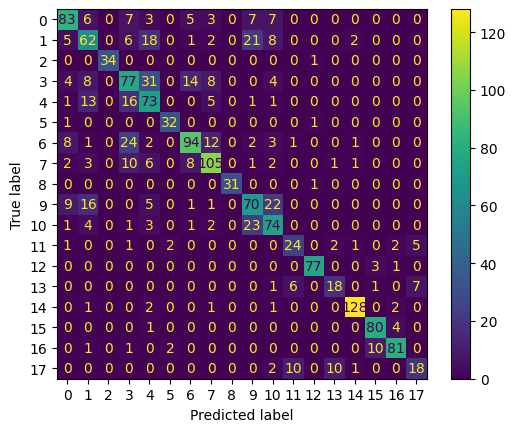

,Prediction,Target
0,10,10
1,9,9
2,16,16
3,1,1
4,11,11
...,...,...
1626,14,14
1627,1,10
1628,0,0
1629,4,1



Valid Sliced

accuracy=0.7118332311465358


In [16]:
import pandas as pd

from transforms import FixLength, Transpose, ToType, ToTensor, Resize, Clip
from torch_evaluation import get_predict_fn, get_slices_fn, get_slices_predict_fn, evaluate_dataset
from core_utilities import make_header

if 'evaluation.valid.sliced' in config.features:
    base_predict_fn = get_predict_fn(model, config.device)
    slices_fn = get_slices_fn(
        slice_dim=0,
        slice_size=data_config.slice_len,
        stride=16,
        transforms=[Clip(limits=(-3.5, 2.5)), FixLength(data_config.sequence_len)]
    )
    predict_fn = get_slices_predict_fn(
        base_predict_fn,
        slices_fn,
        transforms=[
            Transpose(dims=(0, 2, 1)),
            ToType(),
            ToTensor(),
        ])

    # Create a dataset
    dataset = CMIDataset(valid_X, valid_y, transforms=[])

    # Compute predictions and overall accuracy
    y_preds, ys = evaluate_dataset(dataset, predict_fn)
    accuracy = (y_preds == ys).mean()

    # Save predictions
    df = pd.DataFrame(columns=['Prediction', 'Target'])
    df['Prediction'] = y_preds
    df['Target'] = ys
    df.to_pickle('valid.sliced.predictions.pkl')
    display(df)

    print(make_header('Valid Sliced'))
    print(f'{accuracy=}')

In [17]:
import pandas as pd

from transforms import FixLength, Transpose, ToType, ToTensor, Resize, Clip
from torch_evaluation import load_models, get_multi_predict_fn, get_slices_fn, get_slices_predict_fn, evaluate_dataset
from core_utilities import make_header

if 'evaluation.composite.sliced' in config.features:
    # Model Weights
    model_weights = {
        'mixup': Path('/kaggle/input/cmi-behavior-detection-84/weights.pt'),
        'hard-labels': Path('weights.pt'),
    }
    
    # Load all models
    models = load_models(model, model_weights, config.device)

    # base_predict_fn = get_predict_fn(model, config.device)
    base_predict_fn = get_multi_predict_fn(models, config.device)
    slices_fn = get_slices_fn(
        slice_dim=0,
        slice_size=data_config.slice_len,
        stride=16,
        transforms=[Clip(limits=(-3.5, 2.5)), FixLength(data_config.sequence_len)]
    )
    predict_fn = get_slices_predict_fn(
        base_predict_fn,
        slices_fn,
        transforms=[
            Transpose(dims=(0, 2, 1)),
            ToType(),
            ToTensor(),
        ])

    # Create a dataset
    dataset = CMIDataset(valid_X, valid_y, transforms=[])

    # Compute predictions and overall accuracy
    y_preds, ys = evaluate_dataset(dataset, predict_fn)
    accuracy = (y_preds == ys).mean()

    # Save predictions
    df = pd.DataFrame(columns=['Prediction', 'Target'])
    df['Prediction'] = y_preds
    df['Target'] = ys
    df.to_pickle('valid.sliced.predictions.pkl')
    display(df)

    print(make_header('Valid Sliced'))
    print(f'{accuracy=}')

Prediction: 100%|██████████| 1631/1631 [00:06<00:00, 249.81it/s]


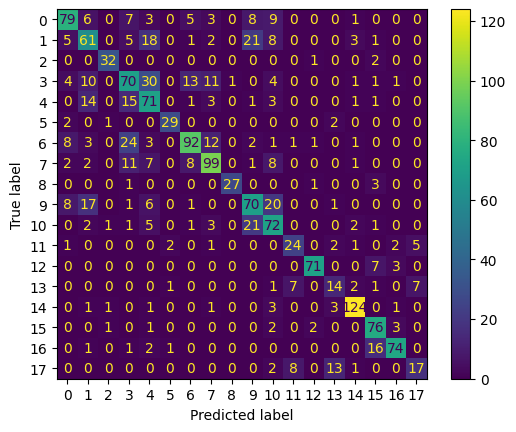

,Prediction,Target
0,10,10
1,1,9
2,16,16
3,1,1
4,11,11
...,...,...
1626,14,14
1627,10,10
1628,0,0
1629,4,1



Valid
=====

accuracy=0.6756591048436542


In [18]:
import pandas as pd

from transforms import FixLength, Transpose, ToType, ToTensor, Resize, Clip
from torch_evaluation import get_predict_fn, evaluate_dataset
from core_utilities import make_header

def Unsqueeze(dim=0):
    def fn(X, y=None):
        X = X.unsqueeze(dim)

        return X if y is None else (X, y)

    return fn

if 'evaluation.valid' in config.features:
    predict_fn = get_predict_fn(model, config.device)

    # Create a dataset22
    transforms = [
        Clip(limits=(-3.5, 2.5)),
        FixLength(data_config.sequence_len),
        Transpose(),
        ToType(),
        ToTensor(),
        Unsqueeze(),
    ]
    dataset = CMIDataset(valid_X, valid_y, transforms=transforms)

    # Compute predictions and overall accuracy
    y_preds, ys = evaluate_dataset(dataset, predict_fn)
    accuracy = (y_preds == ys).mean()

    # Save predictions
    df = pd.DataFrame(columns=['Prediction', 'Target'])
    df['Prediction'] = y_preds
    df['Target'] = ys
    df.to_pickle('valid.predictions.pkl')
    display(df)
    
    print(make_header('Valid'))
    print(f'{accuracy=}')

# predict_fn = get_predict_fn(model, config)

# torch.argmax(predict_fn(torch.tensor(valid_X[0].astype('float32')).unsqueeze(0).transpose(1, 2)))

# Competition Metrics

* We use: https://www.kaggle.com/code/richolson/cmi-2025-metric-copy-for-import

In [19]:
import torch
import pandas as pd

def compute_gestures(dataset, classes, model, config):
    # Compute predictions
    y_probs, ys = get_predictions(
        dataset, 
        predict_fn=get_predict_fn(model, config.device),
        config=config
    )
    y_preds = torch.argmax(y_probs, dim=1).cpu().numpy()
    gestures = pd.Series(y_preds).map(lambda c_idx: classes[c_idx])

    return y_preds, gestures

In [20]:
import pandas as pd

from cmi_2025_metric_copy_for_import import CompetitionMetric
from core_utilities import make_header

def evaluate_valid_score(dataset, classes, model, config):
    preds, preds_gestures = compute_gestures(dataset, classes, model, config)
    y_gestures = pd.Series(y).map(lambda c_idx: classes[c_idx])
    
    submission = pd.DataFrame({'gesture': preds_gestures})
    solution = pd.DataFrame({'gesture': y_gestures})
    
    # Run competition metric
    metric = CompetitionMetric()
    score = metric.calculate_hierarchical_f1(solution, submission)
    print(f"Estimated leaderboard score: {score:.4f}")

if 'competition.metrics.valid' in config.features:
    print(make_header('Valid Gestures'))
    evaluate_valid_score(valid_set, label_encoders[0].classes_, model, valid_config)

## Test

In [21]:
import numpy as np
import pandas as pd

from scipy.spatial.transform import Rotation as R

def remove_gravity_from_acc(acc_values, quat_values):
    # Some variables
    num_samples = acc_values.shape[0]
    linear_accel = np.zeros_like(acc_values)
    gravity_world = np.array([0, 0, 9.81])

    # Iterate over all the samples
    for idx in range(num_samples):
        ## Handle NaN and 0 cases
        if np.all(np.isnan(quat_values[idx])) or np.allclose(quat_values[idx], 0):
            linear_accel[idx, :] = acc_values[idx, :]
        ## Handle valid rotation values cases
        else:
            try:
                rotation = R.from_quat(quat_values[idx], scalar_first=True)
                gravity_frame = rotation.apply(gravity_world, inverse=True)
                linear_accel[idx, :] = acc_values[idx, :] - gravity_frame
            except ValueError:
                 linear_accel[idx, :] = acc_values[idx, :]
    return linear_accel

def get_linear_acc(data, config):
    # Get acceleration and rotation values
    acc_values = data[config.columns('acc')].values
    rot_values = data[config.columns('rot')].values
    
    # Compute linear acceleration values
    linear_acc_values = remove_gravity_from_acc(acc_values, rot_values)

    return linear_acc_values

In [22]:
import warnings
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter

def get_sequence_prep_fn(config, data_config, sm_window=None):
    def fn(sequence_data):
        ## Placeholder for data
        # data = sequence_data[sequence_data.columns]
        data = sequence_data[data_config.sequence_columns()].copy()

        ## Fix tof data
        if data_config.columns('tof'):
            ### Get tof_columns values
            tof_values = data[data_config.columns('tof')].values

            ### Replace -1 with NaN
            tof_values[tof_values == -1.] = np.nan

            ### Compute mean of tof_columns while skipping NaNs
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                tof_mean = np.nan_to_num(np.nanmean(tof_values, axis=0))

            ### Replace NaN with means
            tof_values = np.where(np.isnan(tof_values), tof_mean, tof_values)

            ### Update the DataFrame
            data[data_config.columns('tof')] = tof_values

        if any(feature in config.features for feature in ['data.linear_acc', 'data.linear_acc.overwrite']):
        # if 'data.linear_acc' in config.features:
            linear_acc = pd.DataFrame(
                get_linear_acc(data, data_config),
                columns=data_config.columns('linear_acc'),
                index=data.index,
            )

            if 'data.linear_acc.overwrite' in config.features:
                data[data_config.columns('acc')] = linear_acc
            else:
                # print(data.shape, linear_acc.shape)
                # display(data), display(linear_acc)
                data = pd.concat([data, linear_acc], axis=1)
                # display(data)
                # print(f'After concat:: {data.shape=}')

        ### Fill NaN with the mean value
        means = data.mean().fillna(0)
        data = data.ffill().bfill().fillna(means.to_dict())
        
        ## Data scaling
        data = StandardScaler().fit_transform(data)

        ## Data smoothening
        if sm_window:
            data = savgol_filter(data, sm_window, 3, axis=0)
        
        return data

    return fn

In [23]:
import os
import torch
import kaggle_evaluation.cmi_inference_server

import polars as pl
import pandas as pd

from transforms import FixLength, Transpose, ToType, ToTensor, Resize, Clip
from torch_evaluation import get_predict_fn, get_slices_fn, get_slices_predict_fn
from core_utilities import make_header

# Sequence Builder
test_sequence_prep_fn = get_sequence_prep_fn(config, data_config)

# Class names
class_names = load_pkl(config.data_root / 'class_names.pkl')

# Multi-slice test transforms
base_predict_fn = get_predict_fn(model, config.device)
slices_fn = get_slices_fn(
    slice_dim=0,
    slice_size=data_config.slice_len,
    stride=16,
    transforms=[Clip(limits=(-3.5, 2.5)), FixLength(data_config.sequence_len)]
)

predict_fn = get_slices_predict_fn(
    base_predict_fn,
    slices_fn,
    transforms=[
        Transpose(dims=(0, 2, 1)),
        ToType(),
        ToTensor(),
    ])

@torch.inference_mode()
def predict(sequence: pl.DataFrame, demographics: pl.DataFrame) -> str:
    ## Convert daa
    data = sequence.to_pandas()[data_config.columns(['metadata', 'acc', 'rot', 'thm', 'tof'])]
    demographics_data = demographics.to_pandas()[data_config.columns(['metadata_d', 'd'])]
    
    selection = data_config.sequence_columns()
    data = pd.merge(data, demographics_data, on='subject')[selection]

    ## Normalize
    X = test_sequence_prep_fn(data)

    ## Compute probabilities
    probs = predict_fn(X)

    ## Compute predicted class
    y_label = np.squeeze(torch.argmax(probs, dim=1).cpu().numpy())

    ## Compute gesture
    gesture = class_names[y_label]

    return gesture

if 'competition.metrics.test' in config.features:
    inference_server = kaggle_evaluation.cmi_inference_server.CMIInferenceServer(predict)

    if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
        inference_server.serve()
    else:
        inference_server.run_local_gateway(
            data_paths=(
                '/kaggle/input/cmi-detect-behavior-with-sensor-data/test.csv',
                '/kaggle/input/cmi-detect-behavior-with-sensor-data/test_demographics.csv',
            )
        )
        display(pd.read_parquet('submission.parquet'))
    
# if 'competition.metrics.test' in config.features:
#     print(make_header('Valid Gestures'))
#     evaluate_score(X_test, None, label_encoders[0].classes_, model, valid_config)

,sequence_id,gesture
0,SEQ_000001,Neck - scratch
1,SEQ_000011,Eyelash - pull hair
